In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


In [2]:
nodes = pd.read_csv('data/nodes.csv')
edging = pd.read_csv('data/edging.csv')



In [3]:
nodes['typ'].value_counts()

typ
substation          437
auxillary_T_node     41
plant                24
generator             9
Name: count, dtype: int64

In [11]:
nodes[nodes['typ'] == 'plant'].head()

,Unnamed: 0,v_id,lon,lat,typ,voltage,frequency,name,operator,ref
49,49,50,10.977233,52.169433,plant,NaN,NaN,Kraftwerk Buschhaus,E.ON Kraftwerke GmbH,NaN
53,53,54,8.438468,49.252460,plant,NaN,NaN,Kernkraftwerk Philippsburg,EnBW Kernkraft GmbH,NaN
81,81,82,8.141914,53.564001,plant,NaN,NaN,Uniper Kraftwerk Wilhelmshaven,EON_Netz,NaN
90,90,91,7.304601,52.481791,plant,NaN,NaN,Erdgaskraftwerk Emsland,RWE AG,NaN
114,114,115,6.576482,51.055595,plant,NaN,NaN,RWE Kraftwerk Frimmersdorf,NaN,NaN


In [4]:
nodes.head()

,Unnamed: 0,v_id,lon,lat,typ,voltage,frequency,name,operator,ref
0,0,1,9.522576,52.360409,substation,220000;110000,50,Hannover/West,TenneT;EON_Netz,NaN
1,1,2,9.113210,52.543853,substation,220000,50,Umspannwerk Kraftwerk Robert Frank,TenneT,NaN
2,2,3,9.389745,52.026313,substation,380000;110000,50,UW Grohnde 380 kV / 110 kV,TenneT,NaN
3,3,4,9.125266,52.538264,substation,380000;220000,50,Landesbergen,TenneT TSO GmbH,NaN
4,4,5,10.366275,52.284647,substation,380000;220000,50,Wahle,TenneT,NaN


In [5]:
edging.head()

,Unnamed: 0,l_id,v_id_1,v_id_2,voltage,cables,wires,frequency,name,operator,ref,length_m,r_ohmkm,x_ohmkm,c_nfkm,i_th_max_a,from_relation
0,0,1,1,2,220000,3.0,2.0,50.0,Leitung 2016,TenneT,2016,43396,0.0800,0.320,11.5,1.3,67129.0
1,1,2,3,4,380000,3.0,4.0,50.0,Leitung 3011,TenneT,NaN,72714,0.0250,0.250,13.7,2.6,67131.0
2,2,3,5,6,220000,3.0,2.0,50.0,Leitung 2024,TenneT,1,33954,0.0800,0.320,11.5,1.3,67151.0
3,3,4,7,5,380000,3.0,4.0,50.0,Leitung 3026,TenneT,3026,33483,0.0250,0.250,13.7,2.6,67153.0
4,4,5,8,9,380000,6.0,4.0,50.0,KKW Krümmel - UW Lüneburg,TenneT,NaN,28172,0.0125,0.125,27.4,5.2,67585.0


In [12]:

G = nx.Graph()

for i, row in nodes.iterrows():
    G.add_node(row['v_id'], name = row['name'], lon = row['lon'], lat = row['lat'], type = row['typ'])
    
    
for i, row in edging.iterrows():
    G.add_edge(row['v_id_1'], row['v_id_2'], length = row['length_m'], voltage = row['voltage'], cables = row['cables'], wires = row['wires'], name = row['name'])
    


In [13]:
#nx.write_gexf(G, 'data/power.gexf')

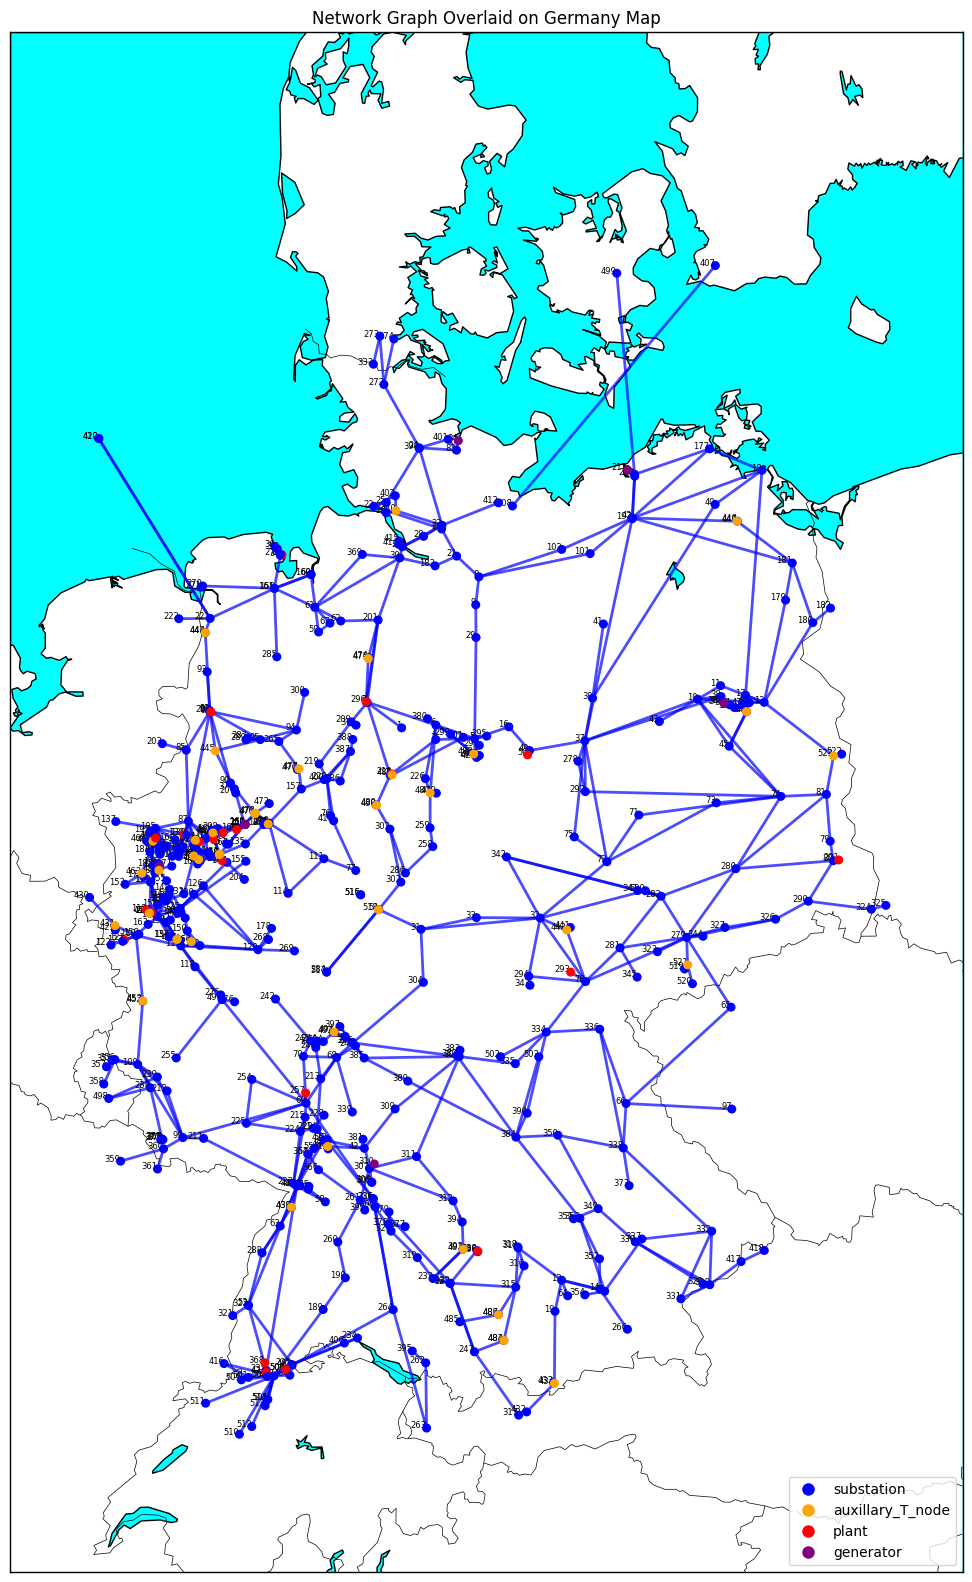

In [40]:
node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}

# Initialize Basemap for Germany
fig, ax = plt.subplots(figsize=(20, 20))
m = Basemap(projection='merc', 
            llcrnrlat=46, urcrnrlat=57, 
            llcrnrlon=5, urcrnrlon=16, 
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='white', lake_color='aqua')

# Convert node positions to map projection
mapped_positions = {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}
node_types = {node: data['type'] for node, data in G.nodes(data=True)}
colormap = {'substation':'blue', 'auxillary_T_node':'orange', 'plant':'red', 'generator':'purple'}
node_colors = [colormap[node_types[node]] for node in G.nodes]

# Draw edges
for (u, v), color in zip(G.edges, edge_colors):
    x = [mapped_positions[u][0], mapped_positions[v][0]]
    y = [mapped_positions[u][1], mapped_positions[v][1]]
    plt.plot(x, y, color="Blue", linewidth=2, alpha=0.7)

# Draw nodes
x, y = zip(*mapped_positions.values())
plt.scatter(x, y, c=node_colors, s=30, zorder=5)

# Add labels
for node, (lon, lat) in node_positions.items():
    x, y = m(lon, lat)
    plt.text(x, y, str(node), fontsize=6, ha='right')
    

handles = [plt.Line2D([0], [0], marker='o', color='w', label=node_type, 
                      markerfacecolor=color, markersize=10) 
           for node_type, color in colormap.items()]
plt.legend(handles=handles, loc='lower right')

plt.title("Network Graph Overlaid on Germany Map")
plt.show()

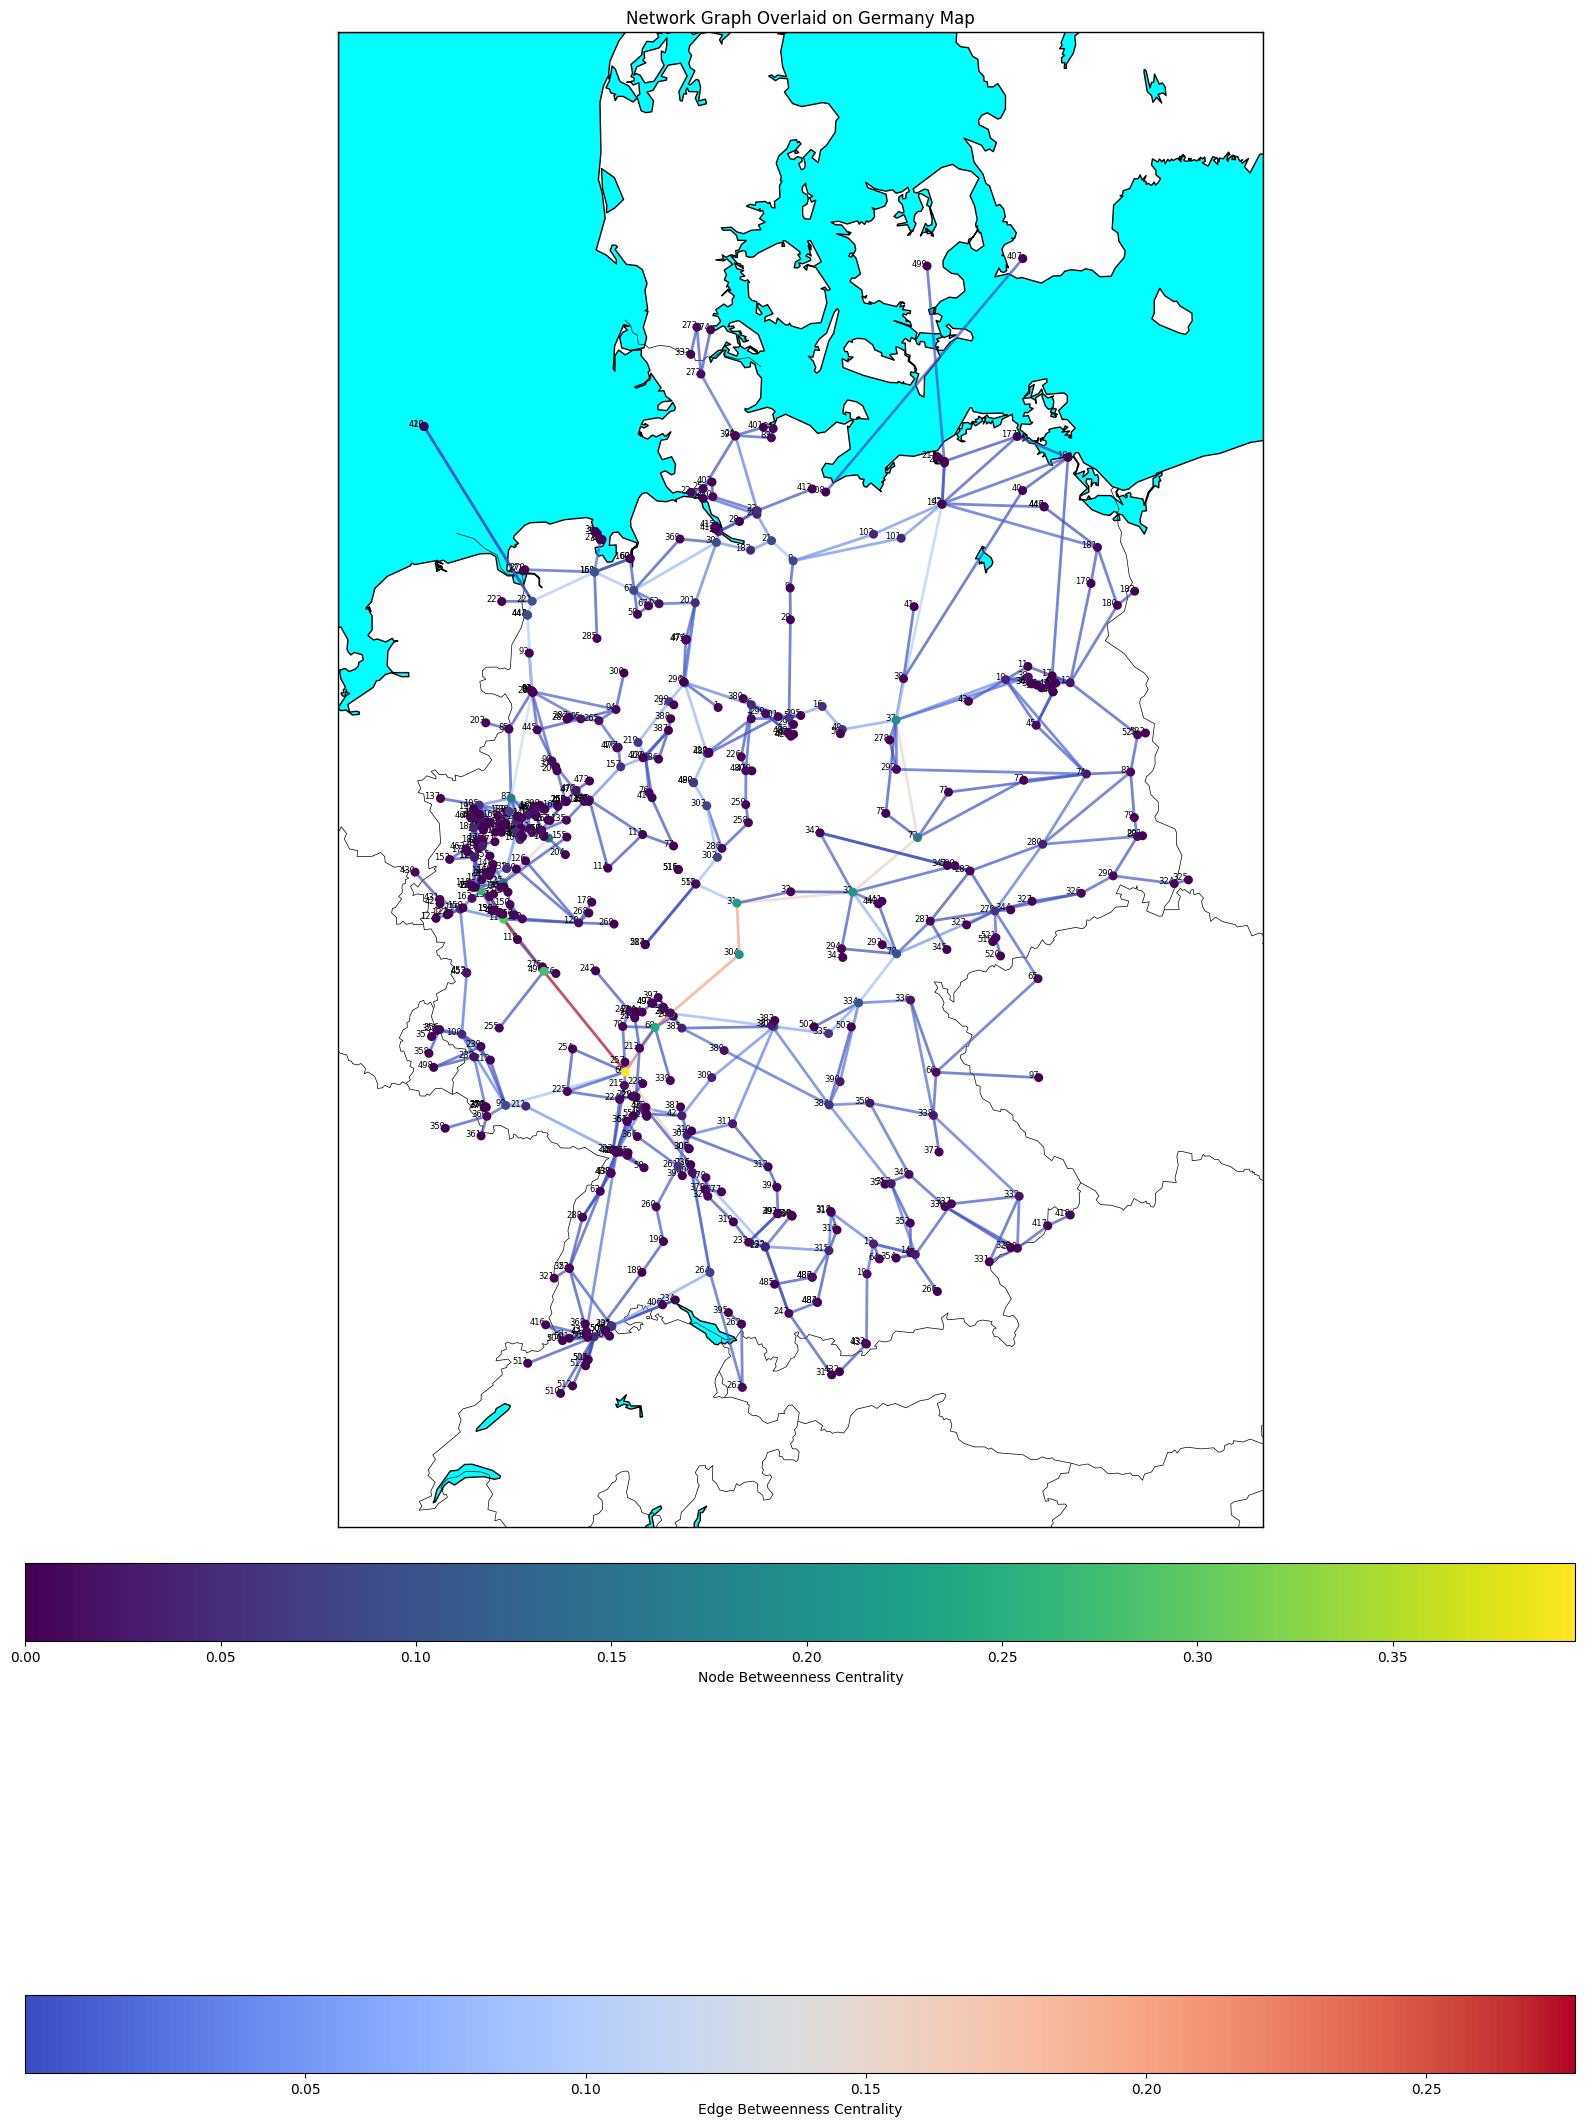

In [38]:
node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}


node_betweenness = nx.betweenness_centrality(G, normalized=True)

max_node_centrality = max(node_betweenness.values())
min_node_centrality = min(node_betweenness.values())
node_colors = [
    (node_betweenness[node] - min_node_centrality) / (max_node_centrality - min_node_centrality)
    for node in G.nodes
]

# Initialize Basemap for Germany
fig, ax = plt.subplots(figsize=(20, 30))
m = Basemap(projection='merc', 
            llcrnrlat=46, urcrnrlat=57, 
            llcrnrlon=5, urcrnrlon=16, 
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='white', lake_color='aqua')

mapped_positions = {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}
node_types = {node: data['type'] for node, data in G.nodes(data=True)}
colormap = {'substation':'blue', 'auxillary_T_node':'orange', 'plant':'red', 'generator':'purple'}
#node_colors = [colormap[node_types[node]] for node in G.nodes]

edge_betweenness = nx.edge_betweenness_centrality(G, normalized=True)

max_edge_centrality = max(edge_betweenness.values())
min_edge_centrality = min(edge_betweenness.values())
edge_colors = [
    (edge_betweenness[(u, v)] - min_edge_centrality) / (max_edge_centrality - min_edge_centrality)
    for u, v in G.edges
]

for (u, v), color in zip(G.edges, edge_colors):
    x = [mapped_positions[u][0], mapped_positions[v][0]]
    y = [mapped_positions[u][1], mapped_positions[v][1]]
    plt.plot(x, y, color=plt.cm.coolwarm(color), linewidth=2, alpha=0.7)

x, y = zip(*mapped_positions.values())
plt.scatter(x, y, c=node_colors, s=30, zorder=5)

for node, (lon, lat) in node_positions.items():
    x, y = m(lon, lat)
    plt.text(x, y, str(node), fontsize=6, ha='right')
    
edge_norm = plt.Normalize(vmin=min_edge_centrality, vmax=max_edge_centrality)
sm_edge = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=edge_norm)
sm_edge.set_array([])  
cbar_edge = fig.colorbar(sm_edge, ax=ax, orientation="horizontal", pad=0.07)
cbar_edge.set_label("Edge Betweenness Centrality")

node_norm = plt.Normalize(vmin=min_node_centrality, vmax=max_node_centrality)
sm_node = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=node_norm)
sm_node.set_array([])  
cbar_node = fig.colorbar(sm_node, ax=ax, orientation="horizontal", pad=0.02)
cbar_node.set_label("Node Betweenness Centrality")

plt.title("Network Graph Overlaid on Germany Map")
plt.show()

In [22]:
import random

def evaluate_network_robustness(graph, num_trials=100):
    edges = list(graph.edges)

    fractions_removed = np.zeros(len(edges))
    fractions_outside_lcc = np.zeros(len(edges))
        
    
    for _ in range(num_trials):
        
        
        edges = list(graph.edges)
        random.shuffle(edges)
        
        num_edges = len(edges)
        num_nodes = len(graph.nodes)
        
        G_copy = graph.copy()
        
        for i, edge in enumerate(edges):
            G_copy.remove_edge(*edge)
            
            largest_cc = max(nx.connected_components(G_copy), key=len)
            size_lcc = len(largest_cc)
            
            fraction_outside = (num_nodes - size_lcc) / num_nodes
            
            fraction_removed = (i + 1) / num_edges
            
            fractions_removed[i] = np.average([fraction_removed, fractions_removed[i]])
            fractions_outside_lcc[i] = np.average([fraction_outside, fractions_outside_lcc[i]])
    
    return fractions_removed, fractions_outside_lcc

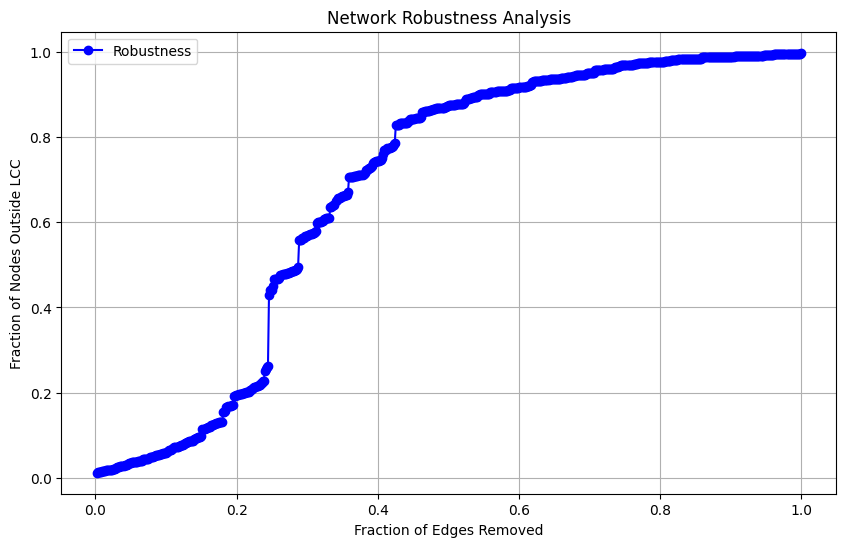

In [28]:
fractions_removed, fractions_outside_lcc = evaluate_network_robustness(G, num_trials=500)

plt.figure(figsize=(10, 6))
plt.plot(fractions_removed, fractions_outside_lcc, marker='o', linestyle='-', color='b', label="Robustness")
plt.title("Network Robustness Analysis")
plt.xlabel("Fraction of Edges Removed")
plt.ylabel("Fraction of Nodes Outside LCC")
plt.grid(True)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Network Graph colored by communities')

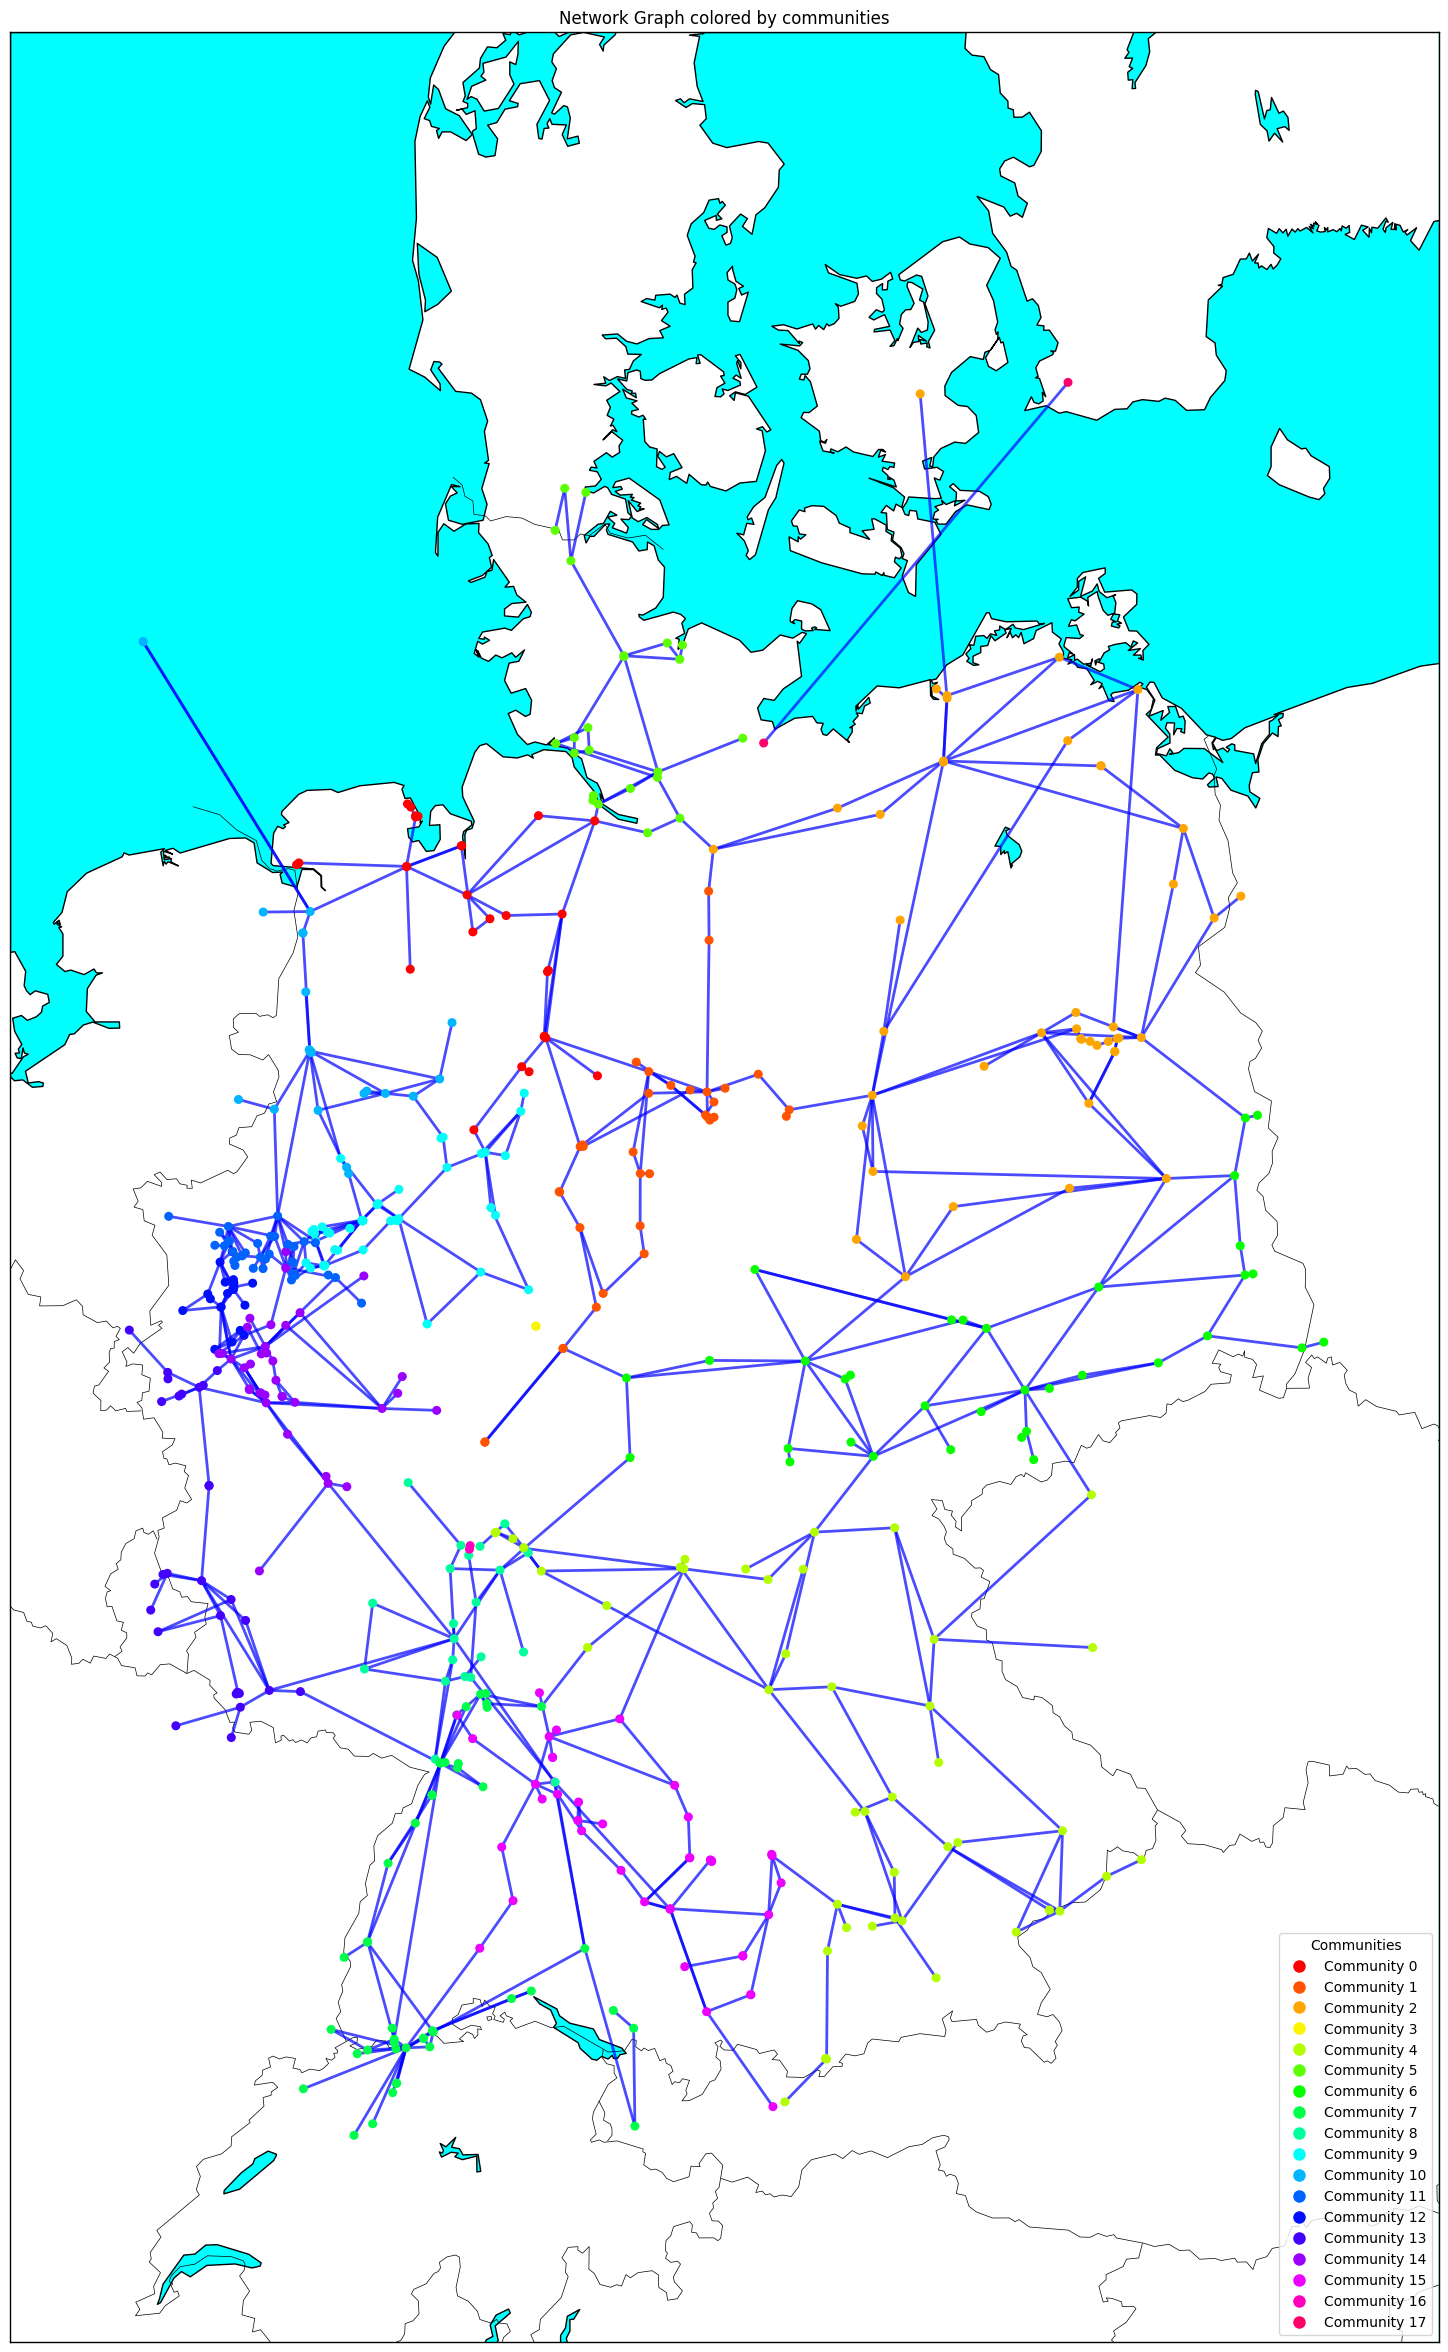

In [55]:
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, "community")

communities = set(partition.values())
colors = plt.cm.hsv([i / len(communities) for i in range(len(communities))])
community_colors = {community: color for community, color in zip(communities, colors)}

fig, ax = plt.subplots(figsize=(20, 30))
m = Basemap(projection='merc', 
            llcrnrlat=46, urcrnrlat=57, 
            llcrnrlon=5, urcrnrlon=16, 
            resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='white', lake_color='aqua')

mapped_positions = {node: m(lon, lat) for node, (lon, lat) in node_positions.items()}

for u, v in G.edges:
    x = [mapped_positions[u][0], mapped_positions[v][0]]
    y = [mapped_positions[u][1], mapped_positions[v][1]]
    plt.plot(x, y, color="Blue", linewidth=2, alpha=0.7)

node_colors = [community_colors[partition[node]] for node in G.nodes]
x, y = zip(*mapped_positions.values())
plt.scatter(x, y, c=node_colors, s=30, zorder=5)

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f"Community {community}",
               markerfacecolor=color, markersize=10)
    for community, color in community_colors.items()
]
plt.legend(handles=legend_handles, title="Communities", loc='lower right', fontsize=10)


plt.title("Network Graph colored by communities")

In [60]:

from collections import defaultdict

community_dict = {node: data['community'] for node, data in G.nodes(data=True)}

outgoing_connections = defaultdict(int)

for u, v in G.edges():
    community_u = community_dict[u]
    community_v = community_dict[v]
    if community_u != community_v: 
        outgoing_connections[community_u] += 1

print("Outgoing connections from each community:")
for community, count in outgoing_connections.items():
    print(f"Community {community}: {count} outgoing connections")

Outgoing connections from each community:
Community 0: 4 outgoing connections
Community 1: 1 outgoing connections
Community 2: 6 outgoing connections
Community 4: 4 outgoing connections
Community 5: 1 outgoing connections
Community 6: 3 outgoing connections
Community 7: 2 outgoing connections
Community 8: 7 outgoing connections
Community 10: 4 outgoing connections
Community 11: 8 outgoing connections
Community 12: 3 outgoing connections
Community 14: 6 outgoing connections
Community 9: 1 outgoing connections
Community 15: 2 outgoing connections


In [57]:
def net_att_val_counts(G, attribute):
    attribute_values = [data[attribute] for _, data in G.nodes(data=True)]
    value_counts = Counter(attribute_values)
    return value_counts

In [58]:

net_att_val_counts(G, 'community')

Counter({0: 28,
         1: 34,
         2: 44,
         4: 45,
         5: 23,
         6: 34,
         7: 45,
         8: 22,
         9: 44,
         10: 23,
         11: 36,
         12: 19,
         13: 29,
         14: 38,
         15: 41,
         16: 2,
         17: 2,
         3: 2})

In [47]:
from collections import Counter
gen = 'generator'
plant = 'plant'

target_nodes = [node for node, data in G.nodes(data=True) if data['type'] == gen or data['type'] == plant]


path_lengths = {node: float('inf') for node in G.nodes}

for target in target_nodes:
    length_to_target = nx.single_source_shortest_path_length(G, target)

    for node, length in length_to_target.items():
        path_lengths[node] = min(path_lengths[node], length)
    
power_path = "path_to_gen_plant"
        
nx.set_node_attributes(G, path_lengths, name=power_path)

for node in target_nodes:
    G.nodes[node]['path_to_gen_plant'] = 0
    

attribute_values = [data[power_path] for _, data in G.nodes(data=True) if power_path in data]

value_counts = Counter(attribute_values)

print("Value counts for attribute:", power_path)
for value, count in value_counts.items():
    print(f"{value}: {count}")



Value counts for attribute: path_to_gen_plant
3: 140
2: 109
1: 34
4: 98
5: 54
6: 20
7: 12
0: 33
inf: 6
8: 3
9: 2
